## Model Compatibility Module

#### Overview
The synthetic data generated by GAN algorithms can be shared with internal business, academic researchers and third parties to tackle business problems. These stakeholders can then use machine learning algorithms on synthetic data to perform future predictions and create strategies as per their needs. In order to serve these needs, the synthetic data generated should have the same utlity as the original data and provide fairly similar prediction if not exactly same. Thus, it's crucial to evaluate if models generated using synthetic data are compatibile with original data? In this module, we will build different machine learning algorithms on 2 different use cases; a) Length of Stay b) Mortality prediction. The description of use cases can be found under <b> Use cases</b> section. These use cases are selected to evaluate both regression and classification models. 

#### Methodology
1. <b> One hot encoding (optional): </b> In case there are any categorical variables required for prediction, we first need to perform one hot encoding. This is done to make sure we don't miss out any categories in test dataset after splitting data into train and test. Example, in case of ethnicity column, there are multiple types like White, Hispanic, Asian, African etc. If we split data into train and test before performing one hot encoding, then there are chances that no Hispanic is present in test data and only present in train data. This can lead to problems while evaluating accuracy of models.
2. <b> Split data into train and test: </b> The analytical data set generated as per the use cases is first split into 2 parts i.e. train and test in the ratio of 80:20. While splitting data set, stratified sampling is performed using the dependent / target variable, duration of stay in use case 1 (length of stay) and expiry flag in use case 2 (mortality prediction). 
3. <b> Generate Synthetic Data: </b> Train dataset is used as an input to GAN algorithms to generate synthetic data of same name of rows. We generated synthetic data using TGAN and CTGAN which was then used to build models.
4. <b> Standarize variables (optional): </b> Numerical variables are present on different scales and some variables cna influence the prediction results more than others. Example, Age and Salary are both numeric variables however, range of salary is much bigger than range of age and thus can impact the prediction results. In order to account for this, we standardized all variables with mean 0 and standard deviation 1. This is same as z-score formula.
5. <b> Model building: </b> Using original train data and synthetic train data (generated by GAN algorithm). For use case 1 (Length of Stay), we used regression algorithms like Regression Tree, Random Forest, XGBoost, Support Vector Machine and K-Nearest Neighbor. For use case 2 (Mortality Prediction), we used classification algrotihms like Logistic Regression, XGBoost and Neural Network. Variety in use cases allows us to evaluate performance of synthetic data on various machine learning algorithms. In classification, due to imbalanced class of target variable, we used parameters within algorithms to assign appropriate weightage to each class.
6. <b> Hyperparameter tuning: </b> 5-fold cross validation is performed along with grid search to perform hyperparameter tuning and selected best combination to improve the models. The metrics to evaluate can be different for different use case example, for mortality prediction, focus is on recall because we want to make sure we predict the patients who are going to die and take actions to save lives.
7. <b> Prediction: </b> Finally, test data is used for prediction based on models generated and range of metrics were reported to compare performance. For classification, metrics like accuracy, precision, recall, f1-score and AUC-ROC. For regression, metrics like Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, Mean Absolute Percentage Error. 


#### Insert Picture from midterm document here

## Model Compatibility Implementation 
### Use Case 2 - Mortality Prediction

#### Code
1. Importing required libraries and csv data for use case 2 (mortality prediction): There are 6 main libraries required to run this module. It includes pandas, sklearn, keras (Neural Network), scikitplot, matplotlib, and xgboost. We are using data set created under <b> Use case </b> section for Use case 2 - Mortality prediction.
2. Filter data and one hot encoding: Data contains fields like SUBJECT_ID and HADM_ID which are unique to each rows and doesn't contribute towards predicting the mortality. Also, we have columns like ETHNICITY and MARITAL_STATUS which are also not good predictors and thus can be removed. After filtering these columns, we need to one hot encod remaining ctaegorical columns like ADMISSION_TYPE and GENDER. 
3. Startified sampling for train test split: HOSPITAL_EXPIRE_FLAG is our target variable and is not balanced. The imbalance ratio is 10:1 i.e. there are 10 non expired patients corresponding to each expired patient in dataset. In order to account for this imabalnce and make sure this ratio is maintained in train and test, we used stratified sampling
4. Generate synthetic data: Post splitting dataset into train and test, we need to generate synthetic data using original train data. This task will be perfomed using TGAN and CTGAN in separate script. We will simply read the synthetic data generated by GAN algorithms in this script.
5. Data correction: The data generated by GAN algorithm treat numeric columns as continous columns rather than only integer values. As it try to replicate the distribution of data, it generate decimal values like 2.45 and also negative values like -2 for these numeric columns. In our use case, we can have only integer values and thud we need to corret data before building models.
6. Model fit function: Function created to train the model and predict using test data
7. Standardize and Hyperparameter tuning: Before implementing machine learning algorithms, we need to standardize data to bring different predictor variables to same scale. This is done to reduce bias caused by variables with high range as compared to other variables. Post which we implemneted Logistic Regression, XGBoost and Neural Network (Multi Layer Perceptron), along with hyperparamter tuning using 5-fold cross validation to select best hyperparamters for model. Also, algorithms are tuned in a way to account for imbalanced data using paramters within function. For detailed understanding , refer to official sklearn documentation. Example Logistic Regression function under sklearn contain parameter for 'class_weight' which can be used to specify imbalanced data.
     - Original data
     - TGAN synthetic data
     - CTGAN synthetic data
8. Compare metrics: There are number of metrics which can be used to compare the performance of classification models. We are reporting testing accuracy, precision, recall, f1-score and auc-roc. However, in case of mortality prediction, we want to make sure we predict patients who are going to die and save lives. So recall for binary class 1 (indicating death) is of utmost importance here. The hyperparameters are also tuned to increase the recall of models.

#### 1. Importing required libraries and csv data for use case 2 (mortality prediction)
Need to first install and then import libraries. There are 6 main libraries required to run this module. It includes pandas, sklearn, keras (Neural Network), scikitplot, matplotlib, and xgboost. We are using data set created under <b> Use case </b> section for Use case 2 - Mortality prediction.

In [14]:
from sklearn import tree, neighbors, datasets, linear_model, svm, naive_bayes
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.utils.multiclass import unique_labels
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import xgboost as xgb
import numpy as np
import pandas as pd
import warnings
from keras import models, regularizers, layers, optimizers, losses
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
warnings.filterwarnings('ignore')

In [3]:
mortality= pd.read_csv("mortality_full_data.csv")

#### 2. One hot encoding
We don't need SUBJECT_ID and HADM_ID as they define the level of data and are unique for each row. We can remove them and other columns which cannot impact the mortality of patient. Example ETHNICITY and MAIRTAL_STATUS have no influence on mortality and can be removed.

In [4]:
#One Hot encoding
mortality_pred=mortality.drop(columns=['SUBJECT_ID','HADM_ID','ETHNICITY','MARITAL_STATUS'])
mortality_pred=pd.get_dummies(mortality_pred,prefix=['ADMISSION_TYPE','GENDER'])
mortality_pred.head()

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,GENDER_M
0,0,0.0,0.0,7,7.0,0.0,0.0,1.0,3.0,2,6.0,91.0,10.0,0,1,0,0,1,0
1,0,0.0,0.0,8,62.0,69.0,0.0,1.0,7.0,4,180.0,208.0,12.0,1,0,0,0,0,1
2,0,1.0,6.0,10,29.0,69.0,4.0,1.0,1.0,5,0.0,221.0,17.0,0,1,0,0,0,1
3,0,0.0,4.0,4,2.0,26.0,0.0,0.0,6.0,3,50.0,99.0,5.0,0,1,0,0,0,1
4,0,0.0,4.0,4,59.0,67.0,0.0,2.0,9.0,4,483.0,315.0,20.0,0,1,0,0,0,1


#### 3. Stratified sampling for train test split
HOSPITAL_EXPIRE_FLAG is our target variable and is not balanced. The imbalance ratio is 10:1 i.e. there are 10 non expired patients corresponding to each expired patient in dataset. In order to account for this imabalnce and make sure this ratio is maintained in train and test, we used stratified sampling

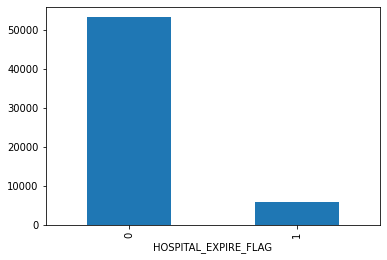

In [5]:
mortality_pred.groupby('HOSPITAL_EXPIRE_FLAG').size().plot.bar()
plt.show()

In [6]:
# Split data using target variable
train, test = train_test_split(mortality_pred, test_size=0.20, random_state=42,stratify=mortality_pred['HOSPITAL_EXPIRE_FLAG'])

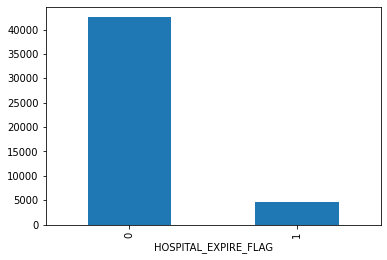

In [7]:
train.groupby('HOSPITAL_EXPIRE_FLAG').size().plot.bar()
plt.show()

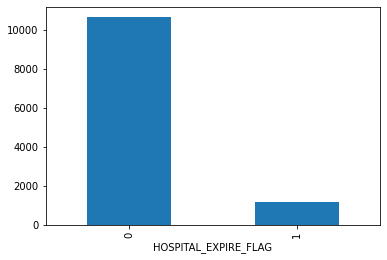

In [8]:
test.groupby('HOSPITAL_EXPIRE_FLAG').size().plot.bar()
plt.show()

In [9]:
# Writing csv files to disk
train.to_csv('mortality_train.csv',index=False)
test.to_csv('mortality_test.csv',index=False)

#### 4. Generate synthetic data
After splitting data set into train and test, we need to generate synthetic data using train data set. We used TGAN and CTGAN for generating synthetic data and will use them in following code to build models.

In [2]:
# Reading data files
train = pd.read_csv("mortality_train.csv")
test = pd.read_csv("mortality_test.csv")
train_tgan=pd.read_csv("mortality_train_tgan.csv")
train_ctgan=pd.read_csv("mortality_train_ctgan.csv")

#### 5. Data Correction
The columns like NUMDIAGNOSIS, NUMRX, etc. consist of number of interactions and are present as integer values. There is no possibility of these values being continous or decimal like 2.45. At the same time there is no possibilty of negative values as number of prescriptions cannot be negative for any patients. However, the data generated by GAN algorithm treat these columns as continous columns rather than only integer values. As it try to replicate the distribution of data, it generate decimal values like 2.45 and also negative values like -2 for number of prescriptions. In order to maintain consistency between original data and synthetic data, we round the decimal places to nearest integer and also change all negative number to 0.

In [3]:
train_tgan=train_tgan.round(0)
train_tgan[train_tgan < 0] = 0
train_tgan.head()

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,GENDER_M
0,0,0.0,37.0,27.0,307.0,198.0,25.0,18.0,16.0,6.0,-0.0,617.0,26.0,1,0,0,0,0,1
1,0,0.0,16.0,9.0,140.0,45.0,-0.0,7.0,9.0,4.0,333.0,451.0,31.0,0,1,0,0,1,0
2,0,1.0,3.0,9.0,37.0,4.0,-0.0,15.0,4.0,3.0,179.0,170.0,22.0,0,1,0,0,1,0
3,0,1.0,5.0,9.0,47.0,72.0,-0.0,5.0,2.0,3.0,88.0,144.0,10.0,0,1,0,0,0,1
4,0,1.0,13.0,14.0,0.0,57.0,-0.0,7.0,3.0,4.0,100.0,637.0,14.0,0,1,0,0,0,0


In [4]:
train_ctgan=train_ctgan.round(0)
train_ctgan[train_ctgan < 0] = 0
train_ctgan.head()

,HOSPITAL_EXPIRE_FLAG,NUMCALLOUT,NUMCPTEVENTS,NUMDIAGNOSIS,NUMOUTEVENTS,NUMRX,NUMPROCEVENTS,NUMMICROLABEVENTS,NUMPROC,NUMTRANSFERS,NUMINPUTEVENTS,NUMLABEVENTS,NUMNOTEVENTS,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,GENDER_M
0,0,0.0,-0.0,5.0,62.0,1.0,-0.0,0.0,5.0,4.0,210.0,202.0,5.0,1,0,0,1,1,0
1,0,0.0,2.0,1.0,2.0,34.0,-0.0,-0.0,0.0,7.0,2.0,17.0,6.0,0,0,0,0,0,1
2,0,1.0,4.0,3.0,22.0,42.0,3.0,1.0,0.0,4.0,49.0,101.0,8.0,0,1,0,0,0,1
3,1,-0.0,7.0,7.0,59.0,35.0,0.0,4.0,2.0,5.0,85.0,264.0,8.0,0,1,0,0,0,1
4,1,-0.0,79.0,25.0,392.0,179.0,56.0,13.0,19.0,7.0,9.0,1827.0,176.0,1,0,0,0,0,1


#### 6. Model fit function
Function created to predict using various machine learning algorithms for classification problems. It takes following inputs:
1. Algorithm (alg)
2. Predictors in train data (x_train)
3. Predictors in test data(x_test)
4. Target variable in train data (y_train)
5. Target variables in test data (y_test)

This function will generate following outputs:
1. Trainig accuracy
2. Testing accuracy
3. Classification report: Contains precision, recall and f1-score for both classes
4. Confusion matrix
5. AUC-ROC: Area under the curve for receiver operating characteristic curve
6. ROC plot
7. Precision-Recall Curve
8. Lift Chart
9. Cumulative Gain chart

In [12]:
# Calculate important metrics like testing accuracy, roc-auc, f1-measure
def model_fit(alg,x_train,x_test,y_train,y_test):
    #fit model
    alg.fit(x_train,y_train)
    #predict using model
    train_predictions=alg.predict(x_train)
    #print report
    print("Training Accuracy: ",round(metrics.accuracy_score(
                y_train.values,train_predictions),2))
    # Predict using testing dataset
    y_test_predict=alg.predict(x_test)
    y_test_predict_prob=alg.predict_proba(x_test)[:,1]
    y_test_predict_prob_both=alg.predict_proba(x_test)
    # Calculate accuracy score on predicted values
    print("Testing Accuracy: ", round(metrics.accuracy_score(
                y_test,y_test_predict),2)," \n")
    print("Classification Report:")
    print(metrics.classification_report(y_test.values,
                y_test_predict))
    print("Confusion Matrix: ")
    print("Actual Predicted")
    labels = list(unique_labels(y_test.values, y_test_predict))
    print(pd.DataFrame(metrics.confusion_matrix(y_test.values,
                    y_test_predict),columns=labels,index=labels))
    print("ROC-AUC: ", round(metrics.roc_auc_score(
                y_test.values,y_test_predict_prob),2))
    # ROC plot
    skplt.metrics.plot_roc(y_test.values, y_test_predict_prob_both)
    plt.show()
    # Precision recall curve
    skplt.metrics.plot_precision_recall(y_test, y_test_predict_prob_both)
    plt.show()
    # Plot Lift chart
    #skplt.metrics.plot_lift_curve(y_test, y_test_predict_prob_both)
    #plt.show()
    # Cumulative gain chart
    #skplt.metrics.plot_cumulative_gain(y_test, y_test_predict_prob_both)
    #plt.show()

#### 7.1 Building Models -  Original data

In [6]:
features=['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS',
       'NUMOUTEVENTS', 'NUMRX', 'NUMPROCEVENTS', 'NUMMICROLABEVENTS',
       'NUMPROC', 'NUMTRANSFERS', 'NUMINPUTEVENTS', 'NUMLABEVENTS',
       'NUMNOTEVENTS', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY',
       'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 'GENDER_F',
       'GENDER_M']
x_train = train[features]
y_train = train['HOSPITAL_EXPIRE_FLAG']
x_test = test[features]
y_test = test['HOSPITAL_EXPIRE_FLAG']

#### Standardize variables

In [7]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

#### Logistic Regression

When it comes to explainability and basics of classifications, Logistic Regression is famous algorithm used by data scientists around the world. We are using sklearn package to implement this algorithm and to account for imbalanced class, we used class_weight ='balanced' parameter. In order to identify best hyperparameters, we are performing 5-fold cross validation along with grid search. Cross validation gives best combination of hyperparameters while maximizing the area under the ROC curve. Best combination from grid search is then used as final hyperparameters for the model.


Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
param_test ={'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'penalty':('l1','l2')}
lr=linear_model.LogisticRegression(random_state=10,multi_class='ovr', class_weight='balanced')
gsearch=GridSearchCV(estimator=lr,
                        param_grid=param_test,
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=True,
                        cv=5)
gsearch.fit(x_train_scaled,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.8268811058211591
Best parameters: {'C': 100, 'penalty': 'l1'}


Logistic regression model 

Training Accuracy:  0.73
Testing Accuracy:  0.73  

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83     10625
           1       0.24      0.80      0.37      1171

    accuracy                           0.73     11796
   macro avg       0.61      0.76      0.60     11796
weighted avg       0.90      0.73      0.78     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  7628  2997
1   229   942
ROC-AUC:  0.83


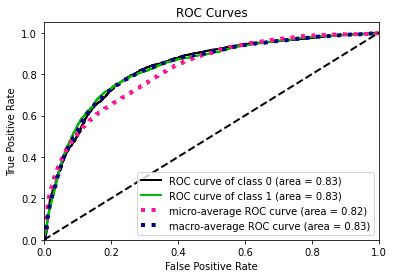

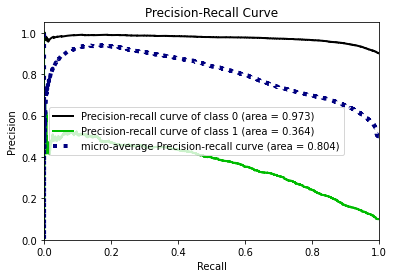

In [18]:
# Model with best parameter
logistic_regression = linear_model.LogisticRegression(C=100,penalty='l1',
                                                      multi_class='ovr',
                                                      class_weight='balanced')
print('Logistic regression model \n')
model_fit(logistic_regression,x_train_scaled,x_test_scaled,y_train,y_test)

#### XGBoost

XGBoost is a decision tree based algorithm which leverages the concept of boosting and regularization to improve the accuracy of model. XGBoost is not present in sklearn package, however it has sklearn based API which can be easily used in python. To account for imbalanced class, we used scale_pos_weight =12 parameter to assign more weight to class with less data because the ratio in which classes are present is 1:12. In order to identify best hyperparameters, we are performing 5-fold cross validation along with grid search. Cross validation gives best combination of hyperparameters while maximizing the area under the ROC curve. Best combination from grid search is then used as final hyperparameters for the model.

Reference: https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [19]:
# Grid Search for best parameters
param_test = {'max_depth':list(range(4,7,1)),
                'learning_rate':list(np.arange(0.2,0.4,0.1)),
                'n_estimator':list(range(100,120,5))}
gsearch=GridSearchCV(estimator=xgb.XGBClassifier(learning_rate =0.1,
                            n_estimators=140,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            njobs=-1,
                            seed=123,
                            scale_pos_weight=9),
                            param_grid=param_test,
                            scoring='roc_auc',
                            n_jobs=-1,
                            iid=True,
                            cv=5)
gsearch.fit(x_train_scaled,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.8889800560078044
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimator': 100}


XGBoost model 

Training Accuracy:  0.8
Testing Accuracy:  0.79  

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87     10625
           1       0.30      0.83      0.44      1171

    accuracy                           0.79     11796
   macro avg       0.64      0.81      0.66     11796
weighted avg       0.91      0.79      0.83     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  8351  2274
1   195   976
ROC-AUC:  0.9


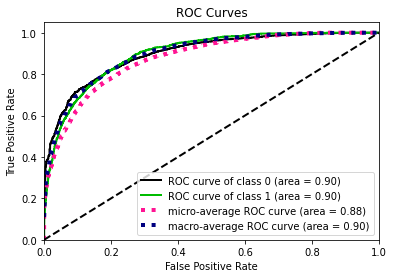

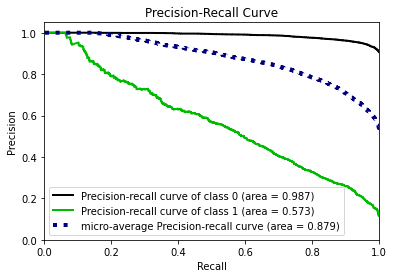

In [20]:
# Model with best parameter
xgboost = xgb.XGBClassifier(n_jobs=-1,random_state=123,
                learning_rate =0.2,
                n_estimators=100,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=12)
print('XGBoost model \n')
model_fit(xgboost,x_train_scaled,x_test_scaled,y_train,y_test)

#### Neural Network

Deep Learning is state of the art when it come to machine learning algorithms. We wanted to implement a neural network to evaluate the utility of synthetic data for new age researchers. Th architecture we have used is below:

Input dimension: 18 neurons<br>
1st Layer: 500 neurons + relu activation function<br>
2nd Layer: Batch normalization<br>
3rd Layer: 500 neurons + relu activation function<br>
4th Layer: Drop out of neurons<br>
5th Layer: 500 neurons + relu activation function<br>
6th Layer: Batch normalization<br>
7th Layer: 500 neurons + relu activation function<br>
8th Layer: Drop out of neurons<br>
9th Layer: Sigmoid activation function<br>

The neural network is using binary cross entropy as loss function and is optimized to maximize area under the ROC curve.

Reference: https://keras.io/getting-started/sequential-model-guide/

In [21]:
def nn_model():
    model = models.Sequential()
    model.add(layers.Dense(500, activation='relu',
                           input_dim=18))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[tf.keras.metrics.AUC()])
    #model.fit(x_train_scaled, y_train, epochs=50, batch_size=500)
    return model

Training Accuracy:  0.84
Testing Accuracy:  0.81  

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.89     10625
           1       0.32      0.78      0.45      1171

    accuracy                           0.81     11796
   macro avg       0.64      0.80      0.67     11796
weighted avg       0.91      0.81      0.84     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  8657  1968
1   261   910
ROC-AUC:  0.87


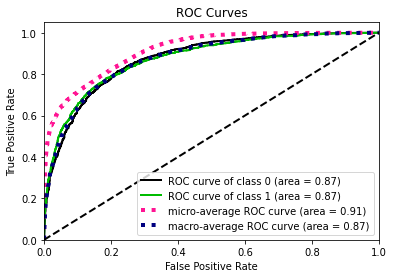

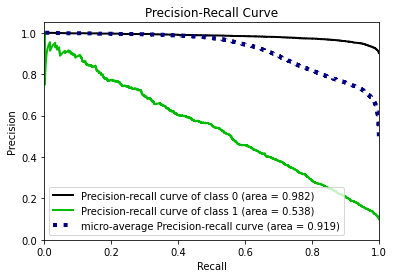

In [22]:
NN = KerasClassifier(build_fn=nn_model, epochs=50, batch_size=200, verbose=0, class_weight={0:1,1:12})
model_fit(NN,x_train_scaled,x_test_scaled,y_train,y_test)

#### 7.2 Building Models -  TGAN data

In [23]:
features=['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS',
       'NUMOUTEVENTS', 'NUMRX', 'NUMPROCEVENTS', 'NUMMICROLABEVENTS',
       'NUMPROC', 'NUMTRANSFERS', 'NUMINPUTEVENTS', 'NUMLABEVENTS',
       'NUMNOTEVENTS', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY',
       'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 'GENDER_F',
       'GENDER_M']
x_train = train_tgan[features]
y_train = train_tgan['HOSPITAL_EXPIRE_FLAG']
x_test = test[features]
y_test = test['HOSPITAL_EXPIRE_FLAG']

#### Standardize the variables

In [24]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

#### Logistic Regression

In [25]:
param_test ={'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'penalty':('l1','l2')}
lr=linear_model.LogisticRegression(random_state=10,multi_class='ovr', class_weight='balanced')
gsearch=GridSearchCV(estimator=lr,
                        param_grid=param_test,
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=True,
                        cv=5)
gsearch.fit(x_train_scaled,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.7813205247298578
Best parameters: {'C': 0.01, 'penalty': 'l1'}


Logistic regression model 

Training Accuracy:  0.7
Testing Accuracy:  0.68  

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     10625
           1       0.21      0.81      0.34      1171

    accuracy                           0.68     11796
   macro avg       0.59      0.74      0.57     11796
weighted avg       0.90      0.68      0.75     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  7116  3509
1   217   954
ROC-AUC:  0.81


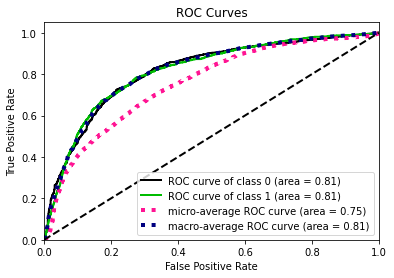

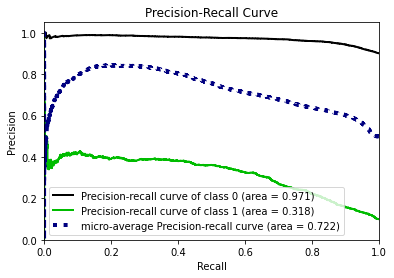

In [26]:
# Model with best parameter
logistic_regression = linear_model.LogisticRegression(C=0.01,penalty='l1',
                                                      multi_class='ovr',
                                                     class_weight='balanced')
print('Logistic regression model \n')
model_fit(logistic_regression,x_train_scaled,x_test_scaled,y_train,y_test)

#### XGBoost

In [27]:
# Grid Search for best parameters
param_test = {'max_depth':list(range(4,7,1)),
                'learning_rate':list(np.arange(0.2,0.4,0.1)),
                'n_estimator':list(range(100,120,5))}
gsearch=GridSearchCV(estimator=xgb.XGBClassifier(learning_rate =0.1,
                            n_estimators=140,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            njobs=-1,
                            seed=123,
                            scale_pos_weight=12),
                            param_grid=param_test,
                            scoring='roc_auc',
                            n_jobs=-1,
                            iid=True,
                            cv=5)
gsearch.fit(x_train_scaled,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.8219386820900801
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimator': 100}


XGBoost model 

Training Accuracy:  0.74
Testing Accuracy:  0.7  

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     10625
           1       0.23      0.83      0.36      1171

    accuracy                           0.70     11796
   macro avg       0.60      0.76      0.58     11796
weighted avg       0.90      0.70      0.76     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  7304  3321
1   198   973
ROC-AUC:  0.84


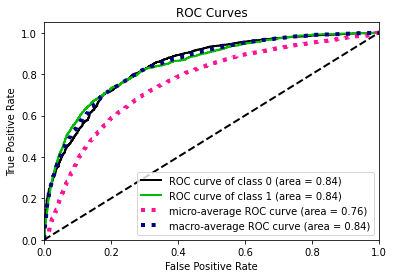

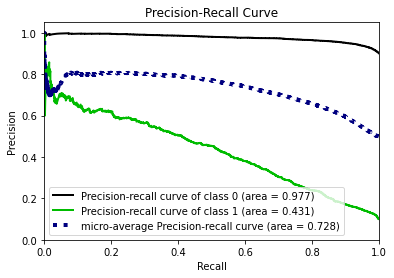

In [28]:
# Model with best parameter
xgboost = xgb.XGBClassifier(n_jobs=-1,random_state=123,
                learning_rate =0.2,
                n_estimators=100,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=12)
print('XGBoost model \n')
model_fit(xgboost,x_train_scaled,x_test_scaled,y_train,y_test)

#### Neural Network

In [29]:
def nn_model():
    model = models.Sequential()
    model.add(layers.Dense(500, activation='relu',
                           input_dim=18))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[tf.keras.metrics.AUC()])
    #model.fit(x_train_scaled, y_train, epochs=50, batch_size=500)
    return model

Training Accuracy:  0.75
Testing Accuracy:  0.69  

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.67      0.80     10625
           1       0.22      0.82      0.34      1171

    accuracy                           0.69     11796
   macro avg       0.59      0.75      0.57     11796
weighted avg       0.90      0.69      0.75     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  7148  3477
1   208   963
ROC-AUC:  0.82


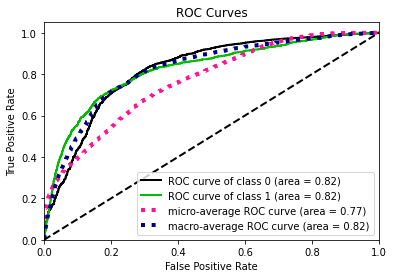

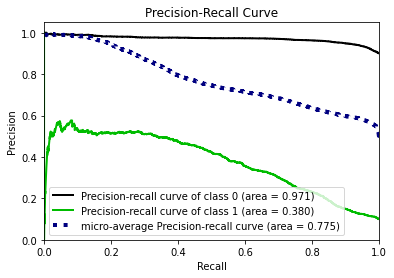

In [30]:
NN = KerasClassifier(build_fn=nn_model, epochs=50, batch_size=100, verbose=0, class_weight={0:1,1:12})
model_fit(NN,x_train_scaled,x_test_scaled,y_train,y_test)

#### 7.3 Building Models -  CTGAN data

In [31]:
features=['NUMCALLOUT', 'NUMCPTEVENTS', 'NUMDIAGNOSIS',
       'NUMOUTEVENTS', 'NUMRX', 'NUMPROCEVENTS', 'NUMMICROLABEVENTS',
       'NUMPROC', 'NUMTRANSFERS', 'NUMINPUTEVENTS', 'NUMLABEVENTS',
       'NUMNOTEVENTS', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY',
       'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 'GENDER_F',
       'GENDER_M']
x_train = train_ctgan[features]
y_train = train_ctgan['HOSPITAL_EXPIRE_FLAG']
x_test = test[features]
y_test = test['HOSPITAL_EXPIRE_FLAG']

#### Standardize variables

In [32]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled=scaler.transform(x_train)
x_test_scaled=scaler.transform(x_test)

#### Logistic Regression

In [33]:
param_test ={'C':[0.001, 0.01, 0.1, 1, 10, 100],
             'penalty':('l1','l2')}
lr=linear_model.LogisticRegression(random_state=10,multi_class='ovr', class_weight='balanced')
gsearch=GridSearchCV(estimator=lr,
                        param_grid=param_test,
                        scoring='roc_auc',
                        n_jobs=-1,
                        iid=True,
                        cv=5)
gsearch.fit(x_train_scaled,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.8016729735853085
Best parameters: {'C': 0.01, 'penalty': 'l2'}


Logistic regression model 

Training Accuracy:  0.7
Testing Accuracy:  0.64  

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.62      0.75     10625
           1       0.19      0.80      0.30      1171

    accuracy                           0.64     11796
   macro avg       0.58      0.71      0.53     11796
weighted avg       0.89      0.64      0.71     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  6578  4047
1   240   931
ROC-AUC:  0.78


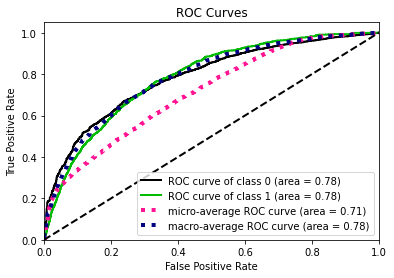

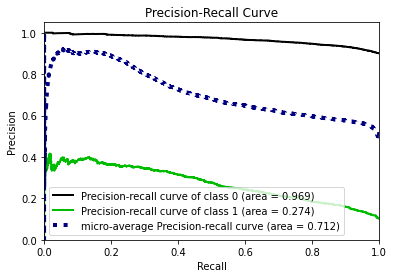

In [34]:
# Model with best parameter
logistic_regression = linear_model.LogisticRegression(C=0.01,penalty='l2',
                                                      multi_class='ovr',
                                                     class_weight='balanced')
print('Logistic regression model \n')
model_fit(logistic_regression,x_train_scaled,x_test_scaled,y_train,y_test)

#### XGBoost

In [35]:
# Grid Search for best parameters
param_test = {'max_depth':list(range(4,7,1)),
                'learning_rate':list(np.arange(0.2,0.4,0.1)),
                'n_estimator':list(range(100,120,5))}
gsearch=GridSearchCV(estimator=xgb.XGBClassifier(learning_rate =0.1,
                            n_estimators=140,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            njobs=-1,
                            seed=123,
                            scale_pos_weight=9),
                            param_grid=param_test,
                            scoring='roc_auc',
                            n_jobs=-1,
                            iid=True,
                            cv=5)
gsearch.fit(x_train_scaled,y_train)
print("Best Score:",gsearch.best_score_)
print("Best parameters:",gsearch.best_params_)

Best Score: 0.8273329818422657
Best parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimator': 100}


XGBoost model 

Training Accuracy:  0.72
Testing Accuracy:  0.67  

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     10625
           1       0.21      0.82      0.33      1171

    accuracy                           0.67     11796
   macro avg       0.59      0.74      0.56     11796
weighted avg       0.89      0.67      0.74     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  6973  3652
1   214   957
ROC-AUC:  0.82


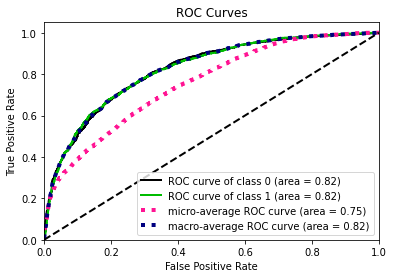

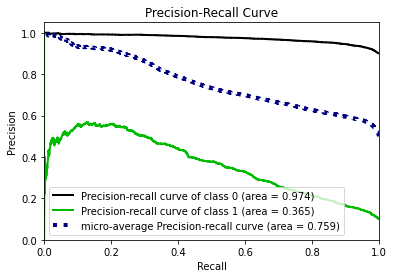

In [36]:
# Model with best parameter
xgboost = xgb.XGBClassifier(n_jobs=-1,random_state=123,
                learning_rate =0.2,
                n_estimators=100,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=12)
print('XGBoost model \n')
model_fit(xgboost,x_train_scaled,x_test_scaled,y_train,y_test)

#### Neural Network

In [37]:
def nn_model():
    model = models.Sequential()
    model.add(layers.Dense(500, activation='relu',
                           input_dim=18))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(500, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[tf.keras.metrics.AUC()])
    #model.fit(x_train_scaled, y_train, epochs=50, batch_size=500)
    return model

Training Accuracy:  0.74
Testing Accuracy:  0.65  

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.64      0.77     10625
           1       0.19      0.77      0.31      1171

    accuracy                           0.65     11796
   macro avg       0.58      0.71      0.54     11796
weighted avg       0.89      0.65      0.72     11796

Confusion Matrix: 
Actual Predicted
      0     1
0  6797  3828
1   267   904
ROC-AUC:  0.79


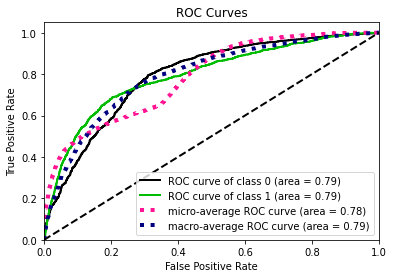

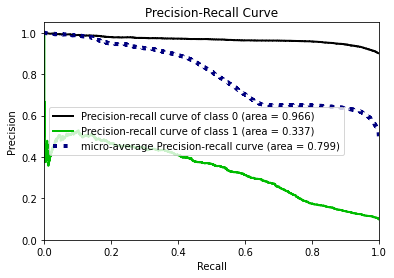

In [38]:
NN = KerasClassifier(build_fn=nn_model, epochs=50, batch_size=100, verbose=0, class_weight={0:1,1:12})
model_fit(NN,x_train_scaled,x_test_scaled,y_train,y_test)

### Results

| Model | Data | Accuracy | Precision | Recall | F1-score | AUC-ROC |
| --- | --- | --- | --- | --- | --- | --- |
| Logistic Regression | Original | 0.73 | 0.24 | 0.80 | 0.37 | 0.83
| Logistic Regression | TGAN Synthetic | 0.68 | 0.21 | 0.81 | 0.34 | 0.81
| Logistic Regression | CTGAN Synthetic | 0.64 | 0.19 | 0.80 | 0.30 | 0.78
| XGBoost | Original | 0.79 | 0.30 | 0.83 | 0.44 | 0.90
| XGBoost | TGAN Synthetic | 0.70 | 0.23 | 0.83 | 0.36 | 0.84
| XGBoost | CTGAN Synthetic | 0.67 | 0.21 | 0.82 | 0.33 | 0.82
| Neural Network | Original | 0.81 | 0.32 | 0.78 | 0.45 | 0.87
| Neural Network | TGAN Synthetic | 0.69 | 0.22 | 0.82 | 0.34 | 0.82
| Neural Network | CTGAN Synthetic | 0.65 | 0.19 | 0.77 | 0.31 | 0.79

### Conclusion

All models were optimized to improve AUC-ROC metric and since we are predicting whether a patient will expire in single admit or no, we need to focus on recall at the same time. From the above table, we can conclude that there is  difference between auc-roc metric for synthetic data for a specific model lies within 9% of original data. Example for Logisitc Regression, auc-roc value are 0.83 (oroginal), 0.81(TGAN) and 0.78(CTGAN). Moreover the range of auc-roc varies a lot among different algorithms like XGBoost ranges between 0.82 to 0.90 whereas Logistic regression ranges between 0.78 to 0.83. So the impact of selecting algorithm is significant as compared to original vs synthetic data. Thus we can assume that any models generated by academic researchers or 3rd parties using synthetic data will perform comparatively on original data. There might be a need to fine tune or re-train the final model to deploy on original data but the heavy lifting can be done by stakeholders with synthetic data.